<a href="https://colab.research.google.com/github/wereketenge/Projects/blob/main/DS_C3_SC2_JosueVillalobos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: /content/mexican-states/mexican-states/mexican-states.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Cleaned columns: ['id', 'nombre', 'direccion', 'ubicacion', 'latitud', 'longitud', 'tel centro llantero']


/tmp/ipython-input-1-3093274931.py:90: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = gdf_buffer.unary_union
/tmp/ipython-input-1-3093274931.py:103: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


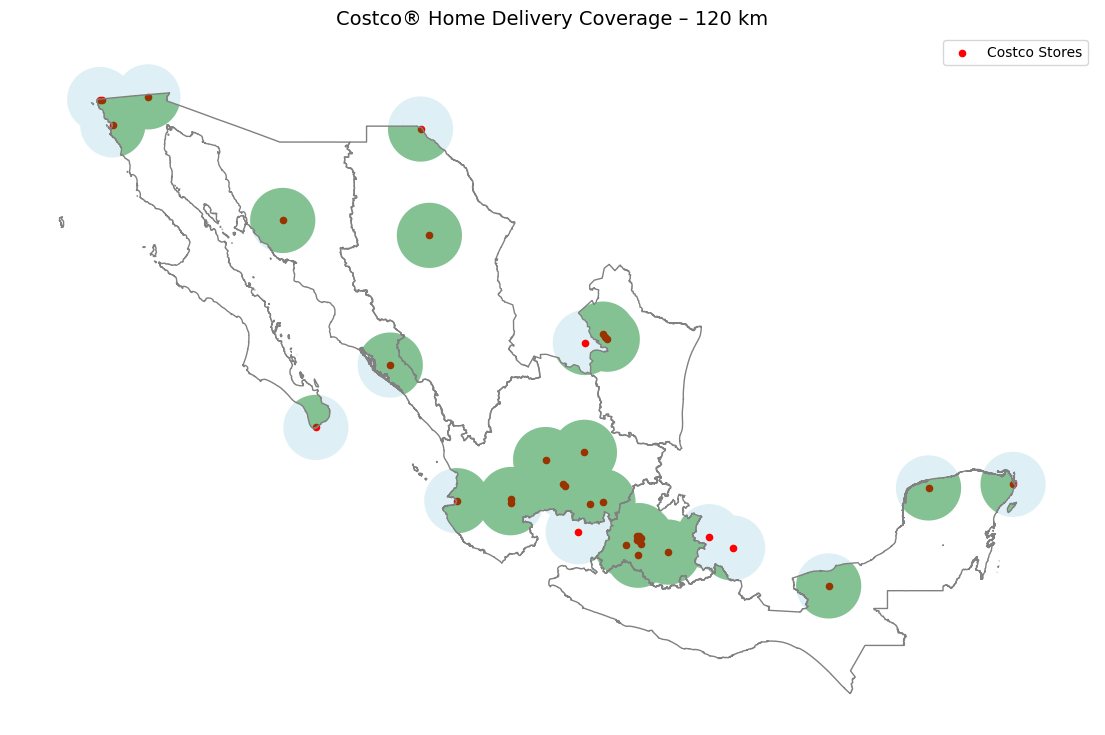

Regions WITHOUT coverage (outside 120 km range):

- Central
- Northeast
- Northwest
- Southeast
- West Central

 Recommendation:
Opening a new store in these regions is NOT recommended due to lack of home delivery coverage from Costco.


In [1]:
# === INSTALL REQUIRED LIBRARIES ===
!pip install --quiet geopandas matplotlib shapely

# === IMPORT LIBRARIES ===
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import zipfile
import os

# === 1. MOUNT GOOGLE DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

# === 2. DEFINE FILE PATHS ===
zip_path = "/content/drive/MyDrive/mexican-states.zip"
csv_path = "/content/drive/MyDrive/tiendaCostco.csv"

# === 3. UNZIP SHAPEFILE INTO TEMP FOLDER ===
output_dir = "/content/mexican-states"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# === 4. READ SHAPEFILE FROM CORRECT PATH ===
gdf_states = gpd.read_file("/content/mexican-states/mexican-states/mexican-states.shp")

# === 5. READ CSV AND CLEAN COLUMN NAMES ===
df_costco = pd.read_csv(csv_path)

# 5.1 Remove extra spaces and convert to lowercase
df_costco.columns = df_costco.columns.str.strip().str.lower()

# 5.2 Confirm column names
print("Cleaned columns:", df_costco.columns.tolist())

# === 6. CREATE GEODATAFRAME FOR COSTCO STORES ===
geometry = [Point(xy) for xy in zip(df_costco['longitud'], df_costco['latitud'])]
gdf_costco = gpd.GeoDataFrame(df_costco, geometry=geometry, crs='EPSG:4326')

# === 7. TRANSFORM CRS TO METERS (EPSG:3395) ===
gdf_costco = gdf_costco.to_crs(epsg=3395)
gdf_states = gdf_states.to_crs(epsg=3395)

# === 8. ASSIGN REGIONS TO STATES ===
regions = {
    'Aguascalientes': 'West Central',
    'Baja California': 'Northwest',
    'Baja California Sur': 'Northwest',
    'Campeche': 'Southeast',
    'Coahuila': 'Northeast',
    'Colima': 'West Central',
    'Chiapas': 'Southeast',
    'Chihuahua': 'Northeast',
    'Ciudad de México': 'Central',
    'Durango': 'Northeast',
    'Guanajuato': 'West Central',
    'Guerrero': 'Southeast',
    'Hidalgo': 'Central',
    'Jalisco': 'West Central',
    'México': 'Central',
    'Michoacán': 'West Central',
    'Morelos': 'Central',
    'Nayarit': 'West Central',
    'Nuevo León': 'Northeast',
    'Oaxaca': 'Southeast',
    'Puebla': 'Central',
    'Querétaro': 'West Central',
    'Quintana Roo': 'Southeast',
    'San Luis Potosí': 'West Central',
    'Sinaloa': 'Northwest',
    'Sonora': 'Northwest',
    'Tabasco': 'Southeast',
    'Tamaulipas': 'Northeast',
    'Tlaxcala': 'Central',
    'Veracruz': 'Southeast',
    'Yucatán': 'Southeast',
    'Zacatecas': 'West Central'
}
gdf_states['REGION'] = gdf_states['name'].map(regions)

# === 9. GROUP BY REGION ===
gdf_regions = gdf_states.dissolve(by="REGION")

# === 10. CREATE 120 KM BUFFER ===
gdf_costco['buffer'] = gdf_costco.buffer(120000)
gdf_buffer = gpd.GeoDataFrame(geometry=gdf_costco['buffer'], crs=gdf_costco.crs)

# === 11. MERGE ALL BUFFERS INTO ONE GEOMETRY ===
buffer_union = gdf_buffer.unary_union
gdf_union = gpd.GeoDataFrame(geometry=[buffer_union], crs=gdf_costco.crs)

# === 12. INTERSECTION BETWEEN REGIONS AND COVERAGE ===
gdf_intersection = gpd.overlay(gdf_regions, gdf_union, how='intersection')

# === 13. MAP VISUALIZATION ===
fig, ax = plt.subplots(figsize=(14, 10))
gdf_regions.boundary.plot(ax=ax, color='gray', linewidth=1)
gdf_union.plot(ax=ax, color='lightblue', alpha=0.4, label='Costco Coverage (120 km)')
gdf_costco.plot(ax=ax, color='red', markersize=20, label='Costco Stores')
gdf_intersection.plot(ax=ax, color='green', alpha=0.4, label='Covered Regions')
plt.title("Costco® Home Delivery Coverage – 120 km", fontsize=14)
plt.legend()
plt.axis('off')
plt.show()

# === 14. FINAL ANALYSIS AND RECOMMENDATION ===
total_regions = gdf_regions.index
covered_regions = gdf_intersection.index
uncovered_regions = list(set(total_regions) - set(covered_regions))

print("Regions WITHOUT coverage (outside 120 km range):\n")
for region in sorted(uncovered_regions):
    print(f"- {region}")

print("\n Recommendation:")
if uncovered_regions:
    print("Opening a new store in these regions is NOT recommended due to lack of home delivery coverage from Costco.")
else:
    print("All regions are covered. A new store can be opened in any area of the country.")
